In [1]:
import pandas as pd
from environment import root_dir
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [120]:
task_vis_results = pd.read_pickle(f"{root_dir}/results/results-tree-vis-v3.pkl")
generation_results = pd.read_pickle(f"{root_dir}/results/results-generation.pkl")
compare_results = pd.read_pickle(f"{root_dir}/results/results-tree-compare.pkl")

In [100]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [59]:
models = {
    "google/gemini-2.0-flash": {
        "label": "Gemini 2.0 Flash", 
        "color": colors[0],
        "marker": markers[0],
        "linestyle": "-",
    },
    "deepseek-ai/deepseek-chat": {
        "label": "DeepSeek-V3", 
        "color": colors[1],
        "marker": markers[1],
        "linestyle": "--",
    },   
}


metrics = {
    "average_forgetting_rate": {
        "label": "Forgetting Rate",
    },
    "average_solution_count": {
        "label": "Average Solution Count",
    },
    "overall_average_verification_rate": {
        "label": "Average Verification Rate",
    },
    "filtered_ajd": {
        "label": "Average Jump Distance",
    },
    "average_success_rate": {
        "label": "Average Success Rate",
    },
    "average_overthinking_rate": {
        "label": "Average Overthinking Rate",
    },
    "average_correlation": {
        "label": "Pass@1",
    },
}

dataset_metrics = {
    "math500": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_correlation",
    ],
    "game24": [
        "average_forgetting_rate",
        "average_solution_count",
        "overall_average_verification_rate",
        "filtered_ajd",
        "average_success_rate",
        "average_overthinking_rate",
        "average_correlation",
    ],
}

final_datasets = {
    'math500': "MATH-500", 
    'game24': "Game of 24",
}
final_metrics = [
    "average_correlation", 
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "average_overthinking_rate",
    "overall_average_verification_rate",
    "average_forgetting_rate",
]

In [5]:
def get_row(df, **kwargs):
    condition = None
    for key, value in kwargs.items():

        if condition is None:
            condition = df[key] == value
        else:
            condition &= df[key] == value
    return df[condition].reset_index(drop=True)

In [6]:
modes = {
    "default": "No Reasoning Examples",
    "ricl_1": "1 Reasoning Example",
    "ricl_2": "2 Reasoning Examples",
    "ricl_3": "3 Reasoning Examples",
}

In [7]:
reasoning_metrics = {}
for dataset in final_datasets:
    reasoning_metrics[dataset] = {}
    for model in models:
        reasoning_metrics[dataset][model] = {}
        for mode in modes:
            row = get_row(
                task_vis_results, 
                model_name=model, 
                dataset_name=dataset, 
                mode = mode,
            )
            reasoning_metrics[dataset][model][mode] = {}
            for metric in final_metrics:
                reasoning_metrics[dataset][model][mode][metric] = row.iloc[0][metric]


In [8]:
alphas = [0.5, 0.7, 0.85, 1.0]  

In [ ]:
this_metrics = [
    "average_correlation",  # Put average_correlation first
    "average_solution_count",
    "filtered_ajd",
    "average_success_rate",
    "overall_average_verification_rate",
    "average_overthinking_rate",
    "average_forgetting_rate",
]

# Create a figure with 2 rows and 4 columns (correlation on left, other metrics on right)
fig, axs = plt.subplots(2, 4, gridspec_kw={'width_ratios': [0.4, 1, 1, 1]})  # Reduced width ratio for correlation column
fig.subplots_adjust(left=0.035, bottom=.05, right=0.995, top=.8, wspace=0.15, hspace=0.3)
fig.set_size_inches(24, 8) 

# Set width of bars
bar_width = 0.1  # For the right side plots with multiple datasets and modes
correlation_bar_width = 0.1  # Narrower bars for the correlation plot to fit all modes

# Set positions of the bars on X axis
index = np.arange(len(final_datasets))

# Restructure data for plotting
# First, create a dictionary where metrics are the top level keys
restructured_metrics = {}
for metric in this_metrics[1:]:  # Skip correlation for now
    restructured_metrics[metric] = {}
    for model in models:
        restructured_metrics[metric][model] = {}
        for mode in modes:
            restructured_metrics[metric][model][mode] = []
            for dataset in final_datasets:
                restructured_metrics[metric][model][mode].append(reasoning_metrics[dataset][model][mode][metric])

# Set the title for the correlation column
metric = "average_correlation"
axs[0, 0].set_title(metrics[metric]["label"], fontsize=28)

# Plot the correlation metric separately in the first column
for i, dataset_key in enumerate(final_datasets):
    dataset_name = final_datasets[dataset_key]
    
    # Plot bars for each model with spacing between groups
    for j, model in enumerate(models):
        # Position the bars with space between model groups but not between modes
        model_offset = 0.1 if j >= 2 else 0  # Add space between model groups
        
        # Store bar positions and heights for connecting lines
        bar_positions = []
        bar_heights = []
        
        for t, mode in enumerate(modes):
            # Calculate position for each mode bar within the model group
            position = j * correlation_bar_width * 5 + t * correlation_bar_width + model_offset  # Increased multiplier from 4 to 5 for more space
            value = reasoning_metrics[dataset_key][model][mode][metric]
            axs[i, 0].bar(position, value, 
                      correlation_bar_width, 
                      label=f"{models[model]['label']} (mode={mode})" if i == 0 and t == 0 else "", 
                      color=models[model]["color"],
                      alpha=alphas[t])
            
            # Add dots at the top of each bar
            axs[i, 0].scatter(position, value, color=models[model]["color"], s=50, zorder=10)
        
        # Add connecting line at the top of bars
        axs[i, 0].plot(bar_positions, bar_heights, color=models[model]["color"], alpha=0.7, linewidth=3)
    
    # Add value labels on top of bars (only for the highest mode for clarity)
    for j, model in enumerate(models):
        model_offset = 0.1 if j >= 2 else 0
        for t, mode in enumerate(modes):
            position = j * correlation_bar_width * 4.5 + t * correlation_bar_width + model_offset  # Increased multiplier from 4 to 5
            value = reasoning_metrics[dataset_key][model][mode][metric]
            
    
    # Set xlabel as dataset name instead of title
    axs[i, 0].set_xlabel(dataset_name, fontsize=28)
    axs[i, 0].set_xticks([])
    axs[i, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    current_ylim = axs[i, 0].get_ylim()
    axs[i, 0].set_ylim(0, current_ylim[1] * 1.15)  # Add 15% padding at the top

# Add a dashed box around the correlation subplots
# Get the position of the first column of subplots
pos0 = axs[0, 0].get_position()
pos1 = axs[1, 0].get_position()
# Create a rectangle patch to surround both correlation subplots
rect = plt.Rectangle(
    (pos0.x0 - 0.03, pos1.y0 - 0.045),  # x, y (bottom left corner)
    pos0.width + 0.035,  # width
    pos0.y0 + pos0.height - pos1.y0 + 0.055,  # height
    linewidth=2,
    linestyle='dashed',
    edgecolor='black',
    facecolor='none',
    zorder=1000,
    transform=fig.transFigure
)
fig.add_artist(rect)

# Create the bar plots for the remaining metrics
for i, metric in enumerate(this_metrics[1:]):  # Skip correlation which we already plotted
    row = i // 3
    col = (i % 3) + 1  # +1 because first column is for correlation
    
    # Calculate positions for bars - centered better
    for j, model in enumerate(models):
        model_offset = 0.1 if j >= 2 else 0  # Add space between model groups
        
        for t, mode in enumerate(modes):
            # Calculate position for each mode bar within the model group
            positions = []
            values = []
            for k in range(len(final_datasets)):
                # Increased multiplier from 4 to 5 for more space between mode groups
                pos = k - bar_width * 10 + j * bar_width * 5 + t * bar_width + model_offset  # Increased from 8 to 10 and 4 to 5
                positions.append(pos)
                values.append(restructured_metrics[metric][model][mode][k])
            
            axs[row, col].bar(positions, values, 
                      bar_width, 
                      label=f"{models[model]['label']} (mode={mode})" if i == 0 and j == 0 and t == 0 else "", 
                      color=models[model]["color"],
                      alpha=alphas[t])
            
            # Add dots at the top of each bar
            for pos, val in zip(positions, values):
                axs[row, col].scatter(pos, val, color=models[model]["color"], s=50, zorder=10)
            
            # Add connecting line at the top of bars for each mode
            if t == len(modes) - 1:  # After plotting all modes for this model
                for dataset_idx in range(len(final_datasets)):
                    # Collect all positions and heights for this dataset and model across modes
                    dataset_positions = []
                    dataset_heights = []
                    for mode_idx, mode_val in enumerate(modes):
                        # Increased multiplier from 4 to 5 for more space between mode groups
                        pos = dataset_idx - bar_width * 9 + j * bar_width * 5 + mode_idx * bar_width + model_offset
                        dataset_positions.append(pos)
                        dataset_heights.append(restructured_metrics[metric][model][mode_val][dataset_idx])
                    
                    # Draw the connecting line
                    axs[row, col].plot(np.array(dataset_positions)-0.1, dataset_heights, color=models[model]["color"], alpha=0.7, linewidth=3)
    
    axs[row, col].set_title(metrics[metric]["label"], fontsize=28)
    axs[row, col].set_xticks(index-0.5)  # Center ticks on clusters
    axs[row, col].set_xticklabels(final_datasets.values())
    axs[row, col].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add a solid line to separate MATH-500 and Game of 24
    axs[row, col].axvline(x=-0.1, color='gray', linestyle='-', linewidth=2, alpha=0.7)
    
    current_ylim = axs[row, col].get_ylim()
    axs[row, col].set_ylim(0, current_ylim[1] * 1.15)  # Add 15% padding at the top
    

# Build custom legend entries
legend_elements = []

# First row: Grok 3 mini beta
# Dummy handle for the model name
legend_elements.append(
    plt.Line2D([], [], linestyle='None', linewidth=0,
               label=f"{models['google/gemini-2.0-flash']['label']}:")
)
# One handle per mode
for t, mode in enumerate(modes):
    legend_elements.append(
        plt.Line2D([0], [0],
                   color=models['google/gemini-2.0-flash']['color'],
                   marker='o', markersize=8, linewidth=3,
                   alpha=alphas[t], label=f"{modes[mode]}")
    )

# Second row: DeepSeek-R1
legend_elements.append(
    plt.Line2D([], [], linestyle='None', linewidth=0,
               label=f"{models['deepseek-ai/deepseek-chat']['label']}:")
)
for t, mode in enumerate(modes):
    legend_elements.append(
        plt.Line2D([0], [0],
                   color=models['deepseek-ai/deepseek-chat']['color'],
                   marker='o', markersize=20, linewidth=3,
                   alpha=alphas[t], label=f"{modes[mode]}")
    )

# Reorder the legend elements to group model name with its modes
reordered_legend_elements = []
reordered_legend_elements.append(legend_elements[0])  # Grok model name
reordered_legend_elements.append(legend_elements[5])  # DeepSeek model name
for i in range(1, 5):
    reordered_legend_elements.append(legend_elements[i])    # Grok mode
    reordered_legend_elements.append(legend_elements[i+5])  # DeepSeek mode


# Place the legend with 5 columns so it wraps into two rows of 5
axs[row, col].legend(
    handles=reordered_legend_elements,
    ncol=5,
    loc='upper center',
    bbox_to_anchor=(-1, 2.9),
    fontsize=22,
    frameon=False,
)

plt.savefig(f"{root_dir}/figures/reasoning_examples.pdf")


In [12]:
items = [
    [
        ("google/gemini-2.0-flash", "default"),
        ("google/gemini-2.0-flash", "ricl_1"),
        ("google/gemini-2.0-flash", "ricl_2"),
        ("google/gemini-2.0-flash", "ricl_3"),
        ("deepseek-ai/deepseek-reasoner", "default"),
    ],
    [
        ("deepseek-ai/deepseek-chat", "default"),
        ("deepseek-ai/deepseek-chat", "ricl_1"),
        ("deepseek-ai/deepseek-chat", "ricl_2"),
        ("deepseek-ai/deepseek-chat", "ricl_3"),
        ("deepseek-ai/deepseek-reasoner", "default"),
    ]
]


In [16]:
similarities = {"tree": {}, "walk": {}}


for item in items:
    item_pairs = list(itertools.combinations(item, 2))
    for (model_name1, mode1), (model_name2, mode2) in item_pairs:
        for dataset in final_datasets:
            model_names_ = [model_name1, model_name2]
            modes_ = [mode1, mode2]
            indices = sorted([0,1], key=lambda i: model_names_[i])
            row = get_row(
                compare_results,
                model1=model_names_[indices[0]],
                model2=model_names_[indices[1]],
                dataset=dataset,
                mode1=modes_[indices[0]],
                mode2=modes_[indices[1]]
            )
            similarities["tree"][(model_names_[indices[0]], model_names_[indices[1]], dataset, modes_[indices[0]], modes_[indices[1]])] = row.iloc[0]["tree_similarity"]
            similarities["walk"][(model_names_[indices[0]], model_names_[indices[1]], dataset, modes_[indices[0]], modes_[indices[1]])] = row.iloc[0]["walk_similarity"]
        
    

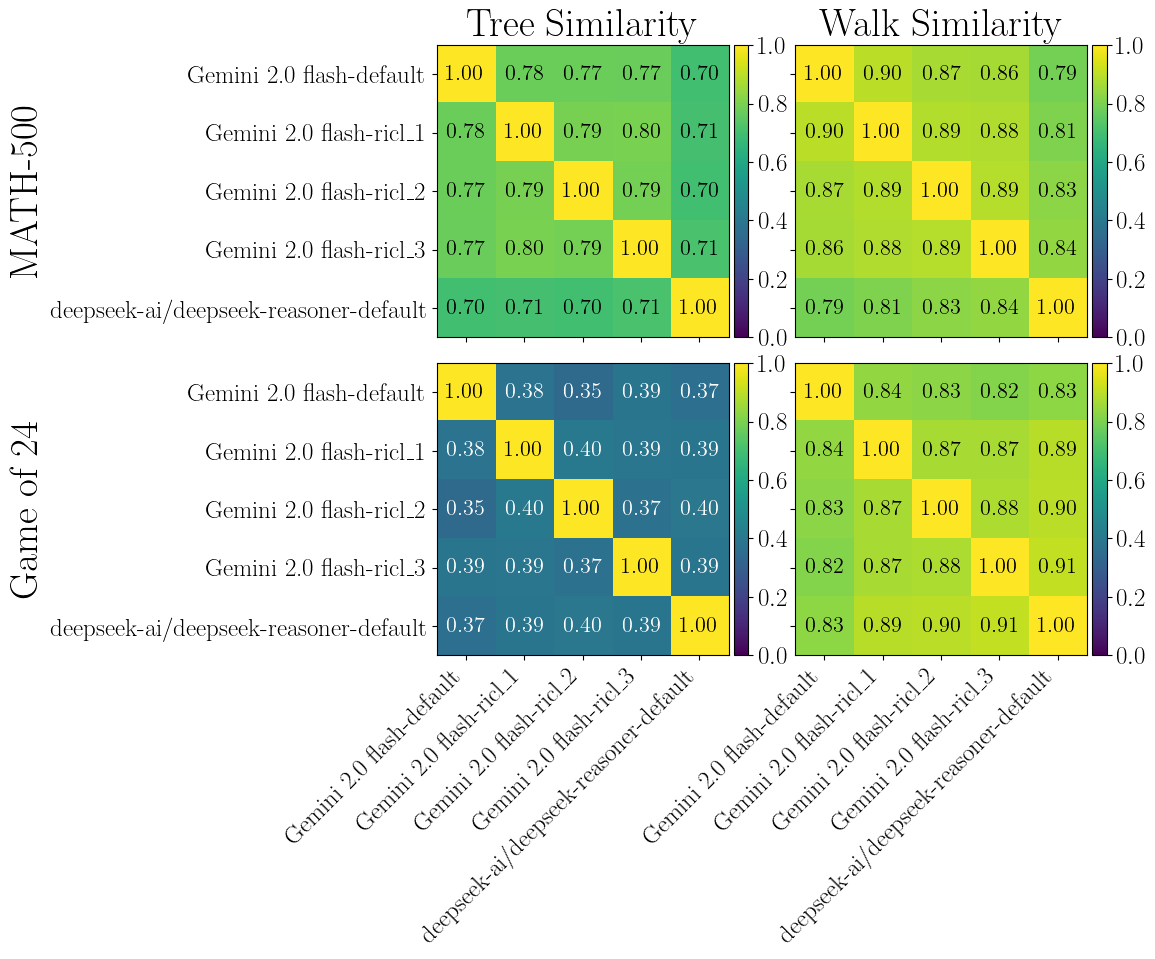

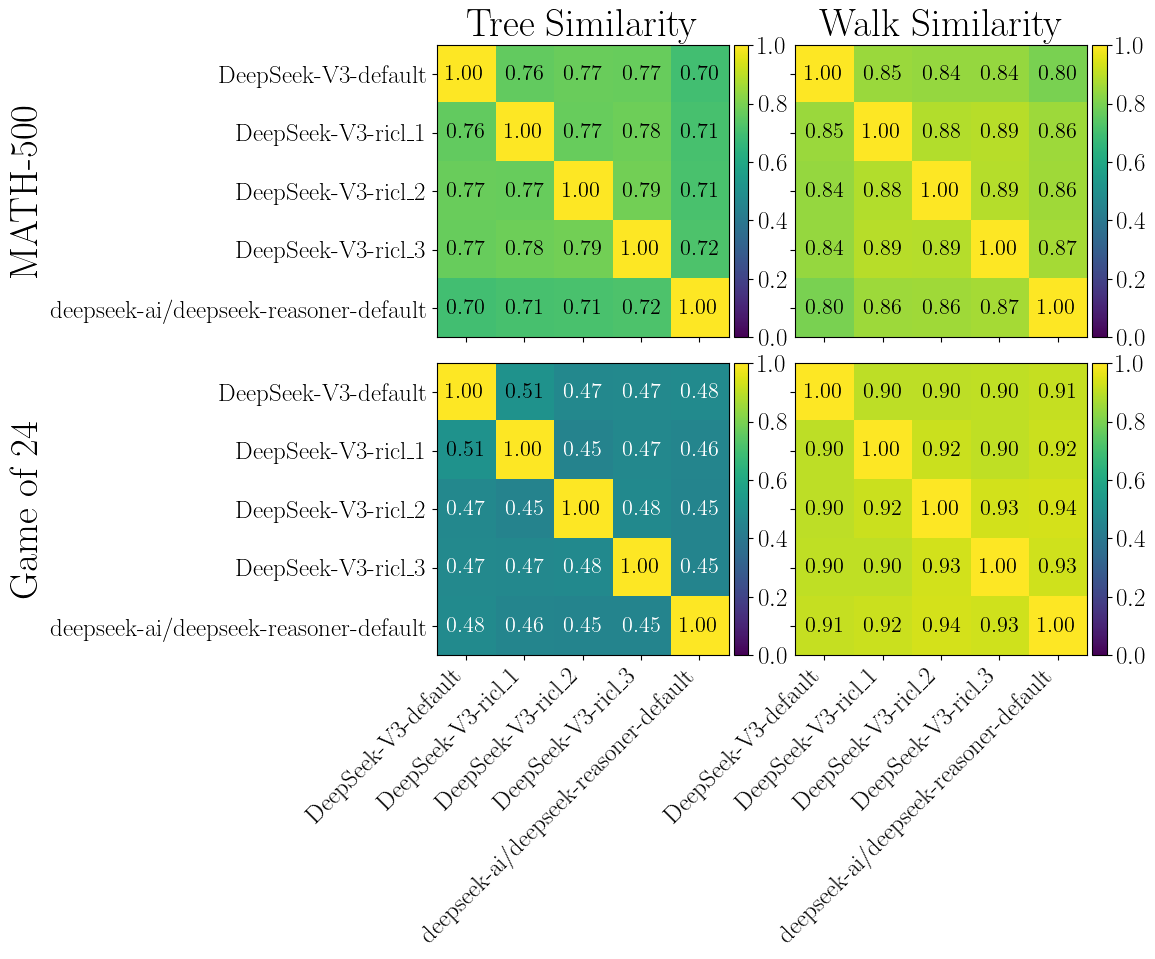

In [17]:
for item_idx, item in enumerate(items):
    # Create a figure with 4 subplots (2x2 grid) for the heatmaps
    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.subplots_adjust(left=0.28, bottom=.1, right=0.95, top=1.05, wspace=0.15, hspace=-0.35)
    fig.set_size_inches(10, 8.5)

    # Define the metrics and datasets for the subplots
    similarity_metrics = ["tree", "walk"]
    datasets_list = list(final_datasets.keys())

    # Extract unique models and modes from this item group
    models_in_item = sorted(list(set([model for model, _ in item])))
    modes_in_item = sorted(list(set([mode for _, mode in item])))
    
    # Create a mapping for configuration values to indices for the heatmap
    config_indices = {i: i for i in range(len(item))}
    config_labels = [f"{models.get(model, {}).get('label', model)}-{mode}" for model, mode in item]

    # Get the model name for this group (using the first item's model name for the title)
    model_name = item[0][0]

    # Create the heatmaps
    for dataset_idx, dataset in enumerate(datasets_list[:2]):  # Using first two datasets
        for metric_idx, metric in enumerate(similarity_metrics):
            # Calculate subplot index
            current_ax = axs[dataset_idx, metric_idx]
            
            # Create empty similarity matrix
            sim_matrix = np.zeros((len(item), len(item)))
            
            # Fill diagonal with 1.0 (self-similarity)
            np.fill_diagonal(sim_matrix, 1.0)
            
            # Fill the matrix with similarity values
            config_pairs = list(itertools.combinations(range(len(item)), 2))
            for i_idx, j_idx in config_pairs:
                model1, mode1 = item[i_idx]
                model2, mode2 = item[j_idx]
                
                # Determine which model name to use as the key
                indices = sorted([0, 1], key=lambda idx: [model1, model2][idx])
                key_model1 = [model1, model2][indices[0]]
                key_model2 = [model1, model2][indices[1]]
                key_mode1 = [mode1, mode2][indices[0]]
                key_mode2 = [mode1, mode2][indices[1]]
                
                # Get similarity value
                sim_value = similarities[metric].get((key_model1, key_model2, dataset, key_mode1, key_mode2), np.nan)
                if not np.isnan(sim_value):
                    sim_matrix[i_idx, j_idx] = sim_value
                    sim_matrix[j_idx, i_idx] = sim_value  # Symmetrical matrix
            
            # Create heatmap
            im = current_ax.imshow(sim_matrix, cmap='viridis', vmin=0, vmax=1)
            
            # Add colorbar with the same height as the heatmap
            divider = make_axes_locatable(current_ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax)
            
            # Make the colorbar tick labels smaller
            cbar.ax.tick_params(labelsize=18)
            
            # Set title and labels
            current_ax.set_xticks(np.arange(len(item)))
            current_ax.set_yticks(np.arange(len(item)))
            current_ax.set_xticklabels(config_labels, rotation=45, ha="right", fontsize=18)
            current_ax.set_yticklabels(config_labels, fontsize=18)
            
            # Add text annotations in the heatmap cells
            for i in range(len(item)):
                for j in range(len(item)):
                    text_color = "white" if sim_matrix[i, j] < 0.5 else "black"
                    current_ax.text(j, i, f"{sim_matrix[i, j]:.2f}", 
                                    ha="center", va="center", color=text_color, fontsize=16)

    # Add y-axis labels for each row (dataset name)
    for dataset_idx, dataset in enumerate(datasets_list[:2]):
        # Add label to the first subplot of each row
        axs[dataset_idx, 0].set_ylabel(final_datasets[dataset], fontsize=28, fontweight='bold')

    # Add x-axis labels at the top for each column (metric name)
    for metric_idx, metric in enumerate(similarity_metrics):
        # Add label to the top subplot of each column
        axs[0, metric_idx].set_title(f"{metric.capitalize()} Similarity", fontsize=28, fontweight='bold')
    

    plt.savefig(f"{root_dir}/figures/reasoning_examples_similarities_group{item_idx+1}.pdf")
    plt.show()


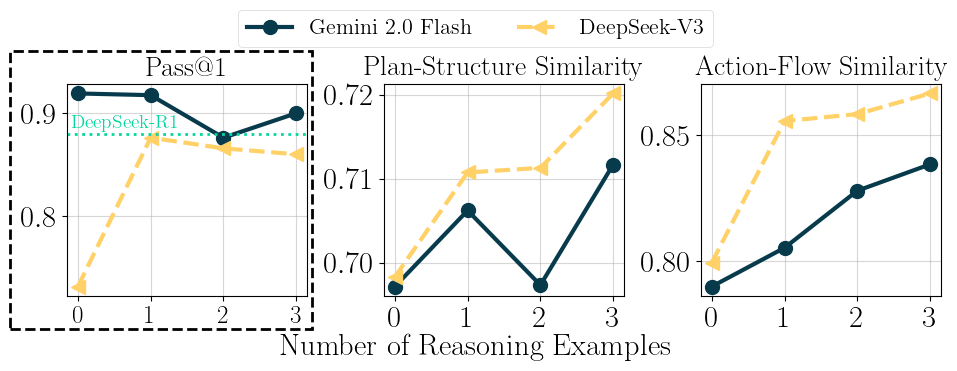

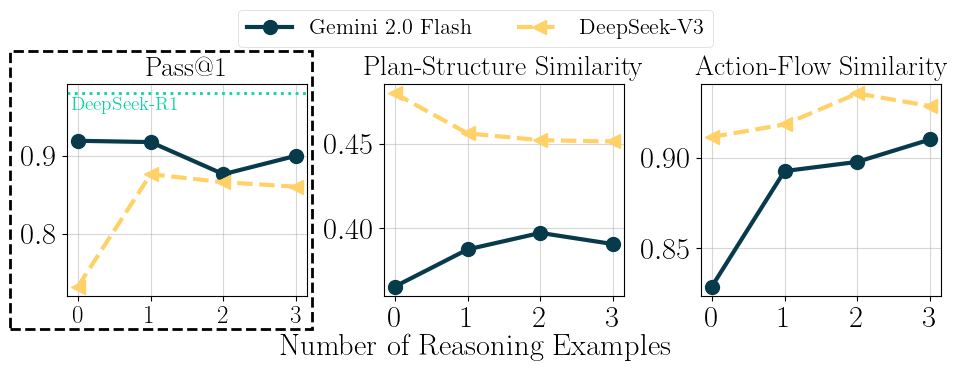

In [151]:
# For each dataset, plot three subplots (one for pass@1, one for each similarity metric), each with two curves (one for each model)
mode_order = ["default", "ricl_1", "ricl_2", "ricl_3"]
mode_x = [0, 1, 2, 3]
mode_label_map = {
    "default": "0",
    "ricl_1": "1",
    "ricl_2": "2",
    "ricl_3": "3"
}

for figure_idx, dataset in enumerate(datasets_list[:2]):
    fig, axs = plt.subplots(1, 3, sharey=False)
    fig.subplots_adjust(left=0.07, bottom=0.19, right=0.99, top=0.78, wspace=0.32)
    fig.set_size_inches(9.5, 3.6)
    
    # Create lines for the legend
    lines = []
    labels = []
    
    # First subplot: average_correlation (pass@1)
    ax = axs[0]
    
    # Get deepseek-reasoner's default pass@1 value for reference line
    deepseek_default_pass = get_row(
        generation_results,
        model_name="deepseek-ai-deepseek-reasoner",
        dataset_name=dataset,
        temperature=0.0
    ).iloc[0]["pass@1"]
    
    for model in models:
        y_values = []
        for mode in mode_order:
            # Get pass@1 values for each mode
            pass_val = reasoning_metrics[dataset_key][model][mode]["average_correlation"]
            y_values.append(pass_val)
        line, = ax.plot(
            mode_x, 
            y_values, 
            marker=models[model]["marker"], 
            color=models[model]["color"], 
            linestyle=models[model]["linestyle"], 
            linewidth=3,
            markersize=10,
        )
        
        # Store the line and label for the legend
        lines.append(line)
        labels.append(models[model]["label"])
    
    # Add horizontal dotted line for deepseek-reasoner's default pass@1
    ax.axhline(y=deepseek_default_pass, color=colors[2], linestyle=':', linewidth=2)
    # Add annotation for the horizontal line
    if figure_idx == 0:
        ax.text(-0.1, deepseek_default_pass+0.01, 'DeepSeek-R1', fontsize=14, va='center', color=colors[2])
    elif figure_idx == 1:
        ax.text(-0.1, deepseek_default_pass-0.015, 'DeepSeek-R1', fontsize=14, va='center', color=colors[2])
    
    ax.set_xticks(mode_x)
    ax.set_xticklabels([mode_label_map[m] for m in mode_order], fontsize=18)
    ax.grid(True, linestyle='-', alpha=0.5)
    ax.set_title("Pass@1", fontsize=20)
    
    # Add a dashed box around the entire pass@1 subplot
    # Get the position of the subplot
    bbox = ax.get_position()
    # Create a rectangle patch with dashed lines
    rect = plt.Rectangle(
        (bbox.x0 - 0.06, bbox.y0 - 0.09),  # Slightly larger than the subplot
        bbox.width + 0.065,  # Add padding
        bbox.height + 0.18,  # Add padding
        fill=False,
        linestyle='--',
        linewidth=2,
        edgecolor='black',
        transform=fig.transFigure
    )
    # Add the rectangle to the figure
    fig.add_artist(rect)
    
    # Similarity metrics in the next two subplots
    for metric_idx, metric in enumerate(similarity_metrics):
        ax = axs[metric_idx + 1]  # +1 because first subplot is for pass@1
        for model in models:
            y_values = []
            for mode in mode_order:
                model_index = sorted([0, 1], key=lambda i: [model, "deepseek-ai/deepseek-reasoner"][i])
                model1 = [model, "deepseek-ai/deepseek-reasoner"][model_index[0]]
                model2 = [model, "deepseek-ai/deepseek-reasoner"][model_index[1]]
                mode1 = [mode, "default"][model_index[0]]
                mode2 = [mode, "default"][model_index[1]]
                sim_val = similarities[metric][(model1, model2, dataset, mode1, mode2)]
                y_values.append(sim_val)
            line, = ax.plot(
                mode_x, 
                y_values, 
                marker=models[model]["marker"], 
                color=models[model]["color"], 
                linestyle=models[model]["linestyle"], 
                linewidth=3,
                markersize=10
            )
                
        ax.set_xticks(mode_x)
        ax.set_xticklabels([mode_label_map[m] for m in mode_order], fontsize=22)
        ax.grid(True, linestyle='-', alpha=0.5)
        if metric_idx == 0:
            ax.set_title("Plan-Structure Similarity", fontsize=20)
        elif metric_idx == 1:
            ax.set_title("Action-Flow Similarity", fontsize=20)
    
    # Add a single legend to the figure
    fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, .85), 
               ncol=len(models), fontsize=16)
    fig.supxlabel("Number of Reasoning Examples", fontsize=22)

    plt.savefig(f"{root_dir}/figures/reasoning_examples_similarity_curve_{dataset}.pdf")
    plt.show()
